      iteration  global_best_fitness                    global_best_position  \
0             1         2.000688e+01  [71.98745748259525, 37.99002563147438]   
1             2         2.000002e+01              [36.99924464753886, 100.0]   
2             3         2.000002e+01              [36.99924464753886, 100.0]   
3             4         2.000002e+01              [36.99924464753886, 100.0]   
4             5         2.000002e+01              [36.99924464753886, 100.0]   
...         ...                  ...                                     ...   
5007       5008        -4.440892e-16                              [0.0, 0.0]   
5008       5009        -4.440892e-16                              [0.0, 0.0]   
5009       5010        -4.440892e-16                              [0.0, 0.0]   
5010       5011        -4.440892e-16                              [0.0, 0.0]   
5011       5012        -4.440892e-16                              [0.0, 0.0]   

      personal_coefficient  global_coef

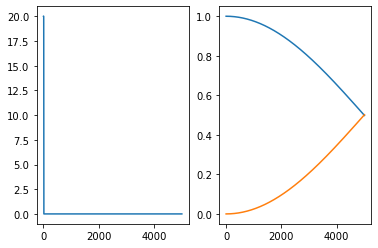

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from optimization.swarmintelligence.particleswarm import ParticleSwarmSystem, Dimension

def easy_bounds(bound):
    return (-bound, bound, -bound, bound)

def check_dim(dim, min = 1):
    assert (type(dim) == int and dim >=min), f"Dimension should be int and not less than {min} for this function (got {dim})"

class Ackley:
    
    b = 100
    
    def __init__(self, dim):
        
        check_dim(dim, 1)
        
        self.x_best = np.zeros(dim)
        self.f_best = 0
        
        self.bounds = easy_bounds(Ackley.b)
        
        self.bias = 20 + math.e
        self.pi2 = 2 * math.pi
    
    def __call__(self, vec):
        
        s1 = sum((x*x for x in vec))/vec.size
        s2 = sum((math.cos(self.pi2 * x) for x in vec))/vec.size
        
        return self.bias - 20*math.exp(-0.2*s1) - math.exp(s2)

## Need to be able to maximise or minimise.
a = Ackley(2)
psystem = ParticleSwarmSystem([Dimension(0.0, 100.0, 5.0), Dimension(0.0, 100.0, 5.0)], a, maximise=False)

result, data = psystem.run(total_particles=100,
                           iterations_limit=10000,
                           stagnation_limit=0.5,
                           coefficient_decay_type="sin")

print(data)

fig, (fitness_axes, coefficient_axes) = plt.subplots(1, 2)
fitness_axes.plot(data["iteration"], data["global_best_fitness"])
coefficient_axes.plot(data["iteration"], data["personal_coefficient"])
coefficient_axes.plot(data["iteration"], data["global_coefficient"])
plt.show()

Best position :: [16.616502155668705 1.3433884712198556 3.9674880947404803]


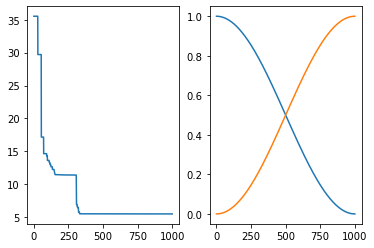

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from optimization.swarmintelligence.particleswarm import ParticleSwarmSystem, Dimension
from control.pid import PIDController
from control.systems import InvertedPendulumSystem
from auxiliary.numpyutils import arg_first_where, get_inflection_points, get_turning_points

pend_system = InvertedPendulumSystem()
controller = PIDController(Kp=0.0, Ki=0.0, Kd=0.0, initial_error=pend_system.get_error())

ticks: int = 100
delta_time: float = 0.1

def control_evaluator(vec):
    Kp, Ki, Kd = vec
    controller.set_gains(Kp, Ki, Kd)
    
    error_values = np.empty(ticks)
    
    for tick in range(ticks):
        error = pend_system.get_error()
        output = controller.control_output(error, delta_time, abs_tol=None)
        pend_system.set_output(output, delta_time)
        error_values[tick] = error
    
    pend_system.reset()
    controller.reset()
    
    ## Integral-time-absolute-error (ITAE)
    itae = np.absolute(error_values * np.full_like(error_values, delta_time).cumsum())
    
    # condition = lambda x: x > 0.0 if error_values[0] < 0.0 else x < 0.0
    # rise_index = arg_first_where(condition, error_values, axis=0, invalid_val=-1)
    points = get_turning_points(error_values)
    if points.size > 0:
        rise_index = points[0]
    else:
        rise_index = -1
    # inflection_points = get_inflection_points(error_values[:rise_index])
    
    if rise_index == -1:
        return itae.sum()
    itae[rise_index:] *= (rise_index + 1)
    return itae.sum()

    # return np.absolute(error_values[rise_index:]).sum() * (rise_index / ticks) + np.absolute(error_values[:rise_index]).sum() * ((ticks - rise_index) / ticks)

psystem = ParticleSwarmSystem([Dimension(0.0, 25.0, 2.5), Dimension(0.0, 25.0, 2.5), Dimension(0.0, 25.0, 2.5)], control_evaluator, maximise=False)

result, data = psystem.run(total_particles=100,
                           iterations_limit=1000,
                           stagnation_limit=0.25,
                           coefficient_decay_type="sin")

print(f"Best position :: {result.best_position}")

fig, (fitness_axes, coefficient_axes) = plt.subplots(1, 2)
fitness_axes.plot(data["iteration"], data["global_best_fitness"])
coefficient_axes.plot(data["iteration"], data["personal_coefficient"])
coefficient_axes.plot(data["iteration"], data["global_coefficient"])
plt.show()


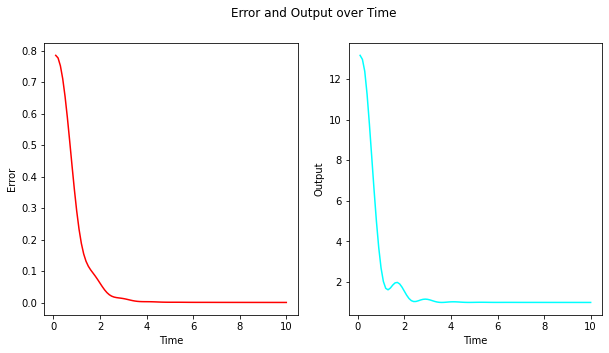

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from control.pid import PIDController
from control.systems import InvertedPendulumSystem

def plot_error(time_points, error_values, output_values) -> None:
    figure, (error_axis, output_axis) = plt.subplots(1, 2)
    figure.suptitle("Error and Output over Time")
    error_axis.plot(time_points, error_values, color="red", label="Error")
    error_axis.set_xlabel("Time"); error_axis.set_ylabel("Error")
    output_axis.plot(time_points, output_values, color="cyan", label="Output")
    output_axis.set_xlabel("Time"); output_axis.set_ylabel("Output")
    figure.subplots_adjust(wspace=0.2)
    figure.set_size_inches(10, 5)

pend_system = InvertedPendulumSystem()
controller = PIDController(*result.best_position, initial_error=pend_system.get_error())

ticks: int = 100
delta_time: float = 0.1

time_points = np.full(ticks, delta_time).cumsum()
error_values = np.empty(ticks)
output_values = np.empty(ticks)

for tick in range(ticks):
    error = pend_system.get_error()
    output = controller.control_output(error, delta_time, abs_tol=None)
    pend_system.set_output(output, delta_time)
    error_values[tick] = error
    output_values[tick] = output
controller.reset()

plot_error(time_points, error_values, output_values)